<a href="https://colab.research.google.com/github/langemittbacken/D7047E_labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install unidecode
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.0 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import torch
import torch.cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [9]:
import unidecode
import string
import random
import re

batch_size = 100
chunk_len = 200
n_epochs = 2000
model = "gru"
learning_rate = 0.01
n_layers = 2
hidden_size = 100
print_every = 100
#shuffle = 

all_characters = string.printable
n_characters = len(all_characters)
filename = read_file('/content/drive/MyDrive/deepNN-labs/shakespear.txt')

file = unidecode.unidecode(open('/content/drive/MyDrive/deepNN-labs/shakespear.txt').read())
file_len = len(file)
print('file_len =', file_len)



file_len = 1115394


In [10]:
import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [7]:
import torch
import os
import argparse

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.to(device)
        prime_input = prime_input.to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.to(device)

    return predicted


In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os

from tqdm import tqdm



# Parse command line arguments


def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    
    if(torch.cuda.is_available()):
      inp = inp.to(device)
      target = target.to(device)
      
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if(torch.cuda.is_available()):
      hidden = hidden.to(device)
      #inp = inp.to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])
        
    loss.backward()
    decoder_optimizer.step()
    return loss.data.item() / chunk_len



# Initialize models and start training

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
if(torch.cuda.is_available()):
  decoder = decoder.to(device)

perplex = []
start = time.time()
all_losses = []
loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
      loss = train(*random_training_set(chunk_len, batch_size))
      loss_avg += loss
      perplex.append(math.exp(loss))
      if epoch % print_every == 0:
          print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
          #print(generate(decoder, 'Wh', 100, True), '\n')



Training for 2000 epochs...


  5%|▌         | 100/2000 [00:40<11:20,  2.79it/s]

 40s (100 5%) 1.8001]


 10%|█         | 200/2000 [01:19<11:01,  2.72it/s]

 19s (200 10%) 1.5782]


 15%|█▌        | 300/2000 [01:58<11:11,  2.53it/s]

 58s (300 15%) 1.4958]


 20%|██        | 400/2000 [02:38<13:42,  1.95it/s]

 38s (400 20%) 1.4434]


 25%|██▌       | 500/2000 [03:17<12:06,  2.07it/s]

 17s (500 25%) 1.4347]


 30%|███       | 600/2000 [03:56<08:24,  2.78it/s]

 56s (600 30%) 1.4012]


 35%|███▌      | 700/2000 [04:35<07:43,  2.81it/s]

 35s (700 35%) 1.4069]


 40%|████      | 800/2000 [05:14<07:11,  2.78it/s]

 14s (800 40%) 1.3825]


 45%|████▌     | 900/2000 [05:54<06:35,  2.78it/s]

 54s (900 45%) 1.3859]


 50%|█████     | 1000/2000 [06:33<06:04,  2.74it/s]

 33s (1000 50%) 1.3900]


 55%|█████▌    | 1100/2000 [07:13<05:40,  2.65it/s]

 13s (1100 55%) 1.3961]


 60%|██████    | 1200/2000 [07:53<05:24,  2.47it/s]

 53s (1200 60%) 1.3895]


 65%|██████▌   | 1300/2000 [08:32<05:45,  2.02it/s]

 32s (1300 65%) 1.3628]


 70%|███████   | 1400/2000 [09:12<05:05,  1.97it/s]

 12s (1400 70%) 1.3887]


 75%|███████▌  | 1500/2000 [09:51<03:11,  2.62it/s]

 51s (1500 75%) 1.3713]


 80%|████████  | 1600/2000 [10:30<02:23,  2.79it/s]

 30s (1600 80%) 1.3309]


 85%|████████▌ | 1700/2000 [11:10<01:47,  2.80it/s]

 10s (1700 85%) 1.3448]


 90%|█████████ | 1800/2000 [11:50<01:11,  2.81it/s]

 50s (1800 90%) 1.3510]


 95%|█████████▌| 1900/2000 [12:30<00:35,  2.80it/s]

 30s (1900 95%) 1.3128]


100%|██████████| 2000/2000 [13:09<00:00,  2.53it/s]

 9s (2000 100%) 1.3452]


Task2

In [14]:
print(generate(decoder, 'bc89l', 100, cuda = True), '\n')
print(generate(decoder, 'bz x9', 100, cuda = True), '\n')
print(generate(decoder, '3ca3s', 100, cuda = True), '\n')

bc89ling soul.

LEONTES:
Look, sir, were you as will begling thee he is,
Madam: and have of Buckingham ma 

bz x9ned we are
happing you at your person him; when, Petruchio!

ARIEL:
Hail that hap doth effect the br 

3ca3s'll not serves I love all moves his ears?

HORTENSIO:
DEens I have them like angeless an art.

ROMEO 



Task 3

In [13]:
print(generate(decoder, 'The', 100, cuda = True), '\n')
print(generate(decoder, 'What is', 100, cuda = True), '\n')
print(generate(decoder, 'Shall I give', 100, cuda = True), '\n')
print(generate(decoder, 'aslkdj alksdncjals', 100, cuda = True), '\n')

Their bears could I have you there imaking have not of speept for the dear
As on the virgined with word 

What is the soul,
To never give thee, pardon the foolish; this is a father's scandon,
And cannot be a cares 

Shall I give and weep, the pawning and fine.
Nay, my makes notups that trachs lost bride,
A seal before her hour 

aslkdj alksdncjals and her wings, be saitory of aught and
the lady's report heavy with what was this prince off.

LUCI 



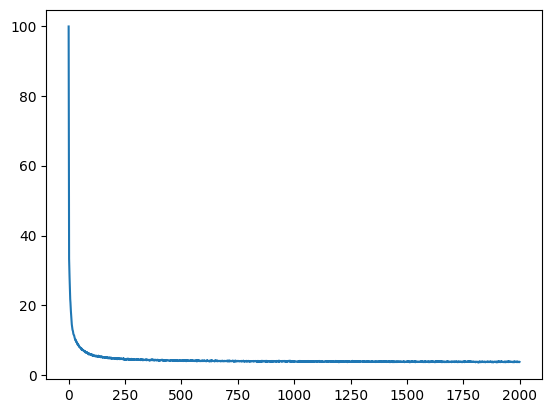

In [12]:


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


plt.figure()
plt.plot(perplex)



In [ ]:
perplex

[101.58414310592902, 65.32600910804842]